In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [4]:
# Load data
train_df = pd.read_csv('./pred_challenge_train_data.csv', delimiter=',')
test_df = pd.read_csv('./pred_challenge_test_data.csv', delimiter=',')
train_df.head()

,ncals,nlogins,prop_withdrawn,age,income,wealth,sex,nprod,churn
0,0,67,0.208455,67.562479,3136.940631,100655.43210,0,1,0
1,2,288,0.064725,66.005370,1775.551353,111804.95730,0,2,0
2,2,45,0.508327,78.108875,7625.352377,163194.06550,1,2,1
3,0,113,0.317960,52.563260,2270.282638,105852.54840,1,3,1
4,8,298,0.295639,32.023677,0.000000,34517.82859,1,2,1


In [5]:
test_df.head()

,ncals,nlogins,prop_withdrawn,age,income,wealth,sex,nprod,churn
0,1,405,0.188828,26.636221,5664.680215,185549.86440,1,1,NaN
1,0,138,0.207633,46.323303,5204.124936,62966.57907,1,5,NaN
2,1,142,0.025344,44.996767,7629.158148,201423.32940,1,3,NaN
3,1,145,0.634990,50.251881,9434.635616,118794.09680,1,5,NaN
4,5,184,0.497226,50.209373,6169.703119,165793.08760,0,3,NaN


In [6]:
# Feature engineering
train_gender_dummies = pd.get_dummies(train_df.sex, prefix='sex')
train_df = train_df.drop('sex',axis = 1)
train_df = train_df.join(train_gender_dummies)

test_gender_dummies = pd.get_dummies(test_df.sex, prefix='sex')
test_df = test_df.drop('sex',axis = 1)
test_df = test_df.join(test_gender_dummies)

In [7]:
train_df.head()

,ncals,nlogins,prop_withdrawn,age,income,wealth,nprod,churn,sex_0,sex_1
0,0,67,0.208455,67.562479,3136.940631,100655.43210,1,0,1,0
1,2,288,0.064725,66.005370,1775.551353,111804.95730,2,0,1,0
2,2,45,0.508327,78.108875,7625.352377,163194.06550,2,1,0,1
3,0,113,0.317960,52.563260,2270.282638,105852.54840,3,1,0,1
4,8,298,0.295639,32.023677,0.000000,34517.82859,2,1,0,1


In [8]:
X_train = train_df.loc[:, train_df.columns != 'churn']
y_train = train_df.churn

X_test = test_df.loc[:, test_df.columns != 'churn']
y_test = test_df.churn

In [9]:
# Function to give best model score and parameters
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    return model.best_score_, model.best_params_, model.best_estimator_
    
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

In [10]:
models = dict({
    'XGBoost': {'classifier':XGBClassifier(), 'params':{'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}},
    'RandomForest': {'classifier':RandomForestClassifier(), 'params':{'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}},
    #'SVC': {'classifier':SVC(), 'params':{'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf','poly'], 'degree':[2,3]}},
    'LogisticRegression': {'classifier': LogisticRegression(solver='lbfgs'), 'params': {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1], 'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}}
})

In [11]:
def grid_search(classifier, params, cv=3, *args, **kwargs):
    grid = GridSearchCV(classifier, params, scoring='accuracy' , cv=cv, refit=True, verbose=0)
    grid.fit(X_train, y_train)
    return best_model(grid)

In [28]:
results = dict()
scores = dict()
test_predictions = dict()
for model, parameters in models.items():
    print(f'---- Working on {model}')
    results[model] = grid_search(**parameters)
    y_pred = results[model][2].predict(X_train)
    y_pred_proba = results[model][2].predict_proba(X_train)[:,1]
    test_predictions[model] = results[model][2].predict(X_test)
    print(classification_report(y_train, y_pred))
    scores[model] = get_auc_scores(y_train, y_pred, y_pred_proba)

---- Working on XGBoost
0.8483333333333333
{'gamma': 0.01, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 20}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       307
           1       0.94      0.96      0.95       293

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg

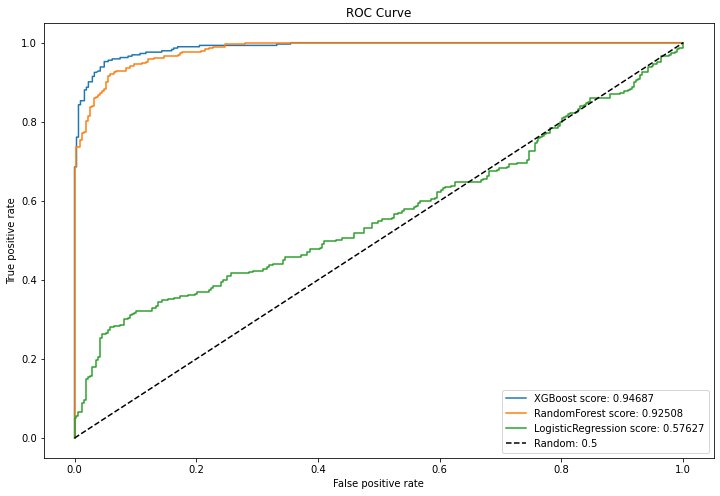

In [29]:
plt.figure(figsize = (12,8), linewidth= 1)
for model, results in scores.items():
    plt.plot(results[1], results[2], label = f'{model} score: {results[0]:.5f}')
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

In [30]:
# find best
best = max(scores.items(), key=lambda x: x[1][0])
print(f'Best model: {best[0]} with AUC={best[1][0]:.5f}')

Best model: XGBoost with AUC=0.94687


In [32]:
final_predictions = test_predictions[best[0]]

In [35]:
assert len(final_predictions) == y_test.shape[0], 'Final predictions is not of the right length'

In [47]:
np.savetxt('./submission.csv', final_predictions.tolist(), fmt='%i')